# IMPORT LIBRARIES & FILES

In [5]:
from config import Config
import pickle

# Data standardisation
from sklearn.preprocessing import StandardScaler

In [1]:
from IPython.utils.io import capture_output
with capture_output() as captured:
    %run data_loader.ipynb
    %run model.ipynb

# SORT DATA

In [2]:
df = df.sort_values(['iso_timestamp', 'station']).reset_index(drop=True)

# SPLIT THE DATA

In [3]:
# get the training length
train_length = int(len(df)*Config.train_size)

# Fit and transform the selected columns
train_df = df[:train_length].copy()
test_df = df[train_length:].copy()

# STANDARDISE THE DATA

In [6]:
scaler = StandardScaler()

# apply standardinsation
train_df[Config.features] = train_df[Config.features].astype(float)
train_df.loc[:,Config.features] = scaler.fit_transform(train_df[Config.features]).astype(float)

test_df[Config.features] = test_df[Config.features].astype(float)
test_df.loc[:,Config.features] = scaler.transform(test_df[Config.features]).astype(float)

df_copy = df.copy()
df = pd.concat([train_df, test_df])

# CREATE INPUTS FOR MODEL 

## CREATE NODE (GCN/GAT)

In [7]:
nodes, node_index_map, index_node_map = create_nodes(filtered_meta_df)
edges, edge_attributes = create_edge_and_attributes(filtered_meta_df)

41 Nodes Created!


Creating Edges & Edge Attributes: 100%|| 41/41 [06:26<00:00,  9.42s/it]

Edges & Edge Attributes Created!!


In [8]:
# Storing the dump_data
dump_data = {
    'nodes': nodes,
    'node_index_map': node_index_map,
    'index_node_map': index_node_map,
    'edges': edges,
    'edge_attributes': edge_attributes
}

with open('graph_data.pkl', 'wb') as f:
    pickle.dump(dump_data, f)

In [9]:
# Reading the dump_data
with open('graph_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Accessing the loaded dump_data
nodes = loaded_data['nodes']
node_index_map = loaded_data['node_index_map']
index_node_map = loaded_data['index_node_map']
edges = loaded_data['edges']
edge_attributes = loaded_data['edge_attributes']

## CREATE GRID MAPPING (CNN)

In [10]:
grid_mapping = create_grid_mapping(filtered_meta_df, 4, node_index_map, lat_range=None, lon_range=None)

## CREATE GRAPH & GRID

### 1. Next 30 mins (SHORT-TERM)

In [11]:
y_ts_start, y_ts_end, y_ts_step, st_output_channels = Config.create_y_range(pred_hour=0)
x_ts_start_latest, x_ts_end_latest, x_ts_step_latest = Config.create_x_range(focus_timeframe = 0)
x_ts_start_lastweek, x_ts_end_lastweek, x_ts_step_lastweek = Config.create_x_range(focus_timeframe = 2016)

#### Input Graphs

In [13]:
print ("SHORT TERM PREDICTION: Creating Most Recent Available Data Based Graph")
print ("======================================================================")
st_graph_latest, st_graph_timestamp_latest = create_graphs(df, Config.features, Config.output, edges, edge_attributes, x_ts_start_latest, x_ts_end_latest, x_ts_step_latest, y_ts_start, y_ts_end, y_ts_step)
st_graph_latest, st_graph_timestamp_latest = match_input_dim(st_graph_latest, st_graph_timestamp_latest)

print ("SHORT TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Graph")
print ("============================================================================")
st_graph_lastweek, st_graph_timestamp_lastweek = create_graphs(df, Config.features, Config.output, edges, edge_attributes, x_ts_start_lastweek, x_ts_end_lastweek, x_ts_step_lastweek, y_ts_start, y_ts_end, y_ts_step)
st_graph_lastweek, st_graph_timestamp_lastweek = match_input_dim(st_graph_lastweek, st_graph_timestamp_lastweek)


SHORT TERM PREDICTION: Creating Most Recent Available Data Based Graph


100%|███████████████████████████████████████| 8928/8928 [06:05<00:00, 24.40it/s]


SHORT TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Graph


100%|███████████████████████████████████████| 8928/8928 [08:11<00:00, 18.18it/s]


#### Input Grids

In [14]:
print ("SHORT-TERM PREDICTION: Creating Most Recent Available Data Based Grid")
print ("=====================================================================")
st_grid_latest, st_grid_timestamp_latest = create_grids(df, Config.features, Config.output, grid_mapping, x_ts_start_latest, x_ts_end_latest, x_ts_step_latest, y_ts_start, y_ts_end, y_ts_step)
st_grid_latest, st_grid_timestamp_latest = match_input_dim(st_grid_latest, st_grid_timestamp_latest)

print ("SHORT-TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Grid")
print ("===========================================================================")
st_grid_lastweek, st_grid_timestamp_lastweek = create_grids(df, Config.features, Config.output, grid_mapping, x_ts_start_lastweek, x_ts_end_lastweek, x_ts_step_lastweek, y_ts_start, y_ts_end, y_ts_step)
st_grid_lastweek, st_grid_timestamp_lastweek = match_input_dim(st_grid_lastweek, st_grid_timestamp_lastweek)


SHORT-TERM PREDICTION: Creating Most Recent Available Data Based Grid


100%|███████████████████████████████████████| 8928/8928 [06:23<00:00, 23.27it/s]


SHORT-TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Grid


100%|███████████████████████████████████████| 8928/8928 [08:25<00:00, 17.68it/s]


#### Match Input Length

In [15]:
st_grid_latest = st_grid_latest[st_grid_timestamp_latest.index(st_grid_timestamp_lastweek[0]):]
st_graph_latest = st_graph_latest[st_graph_timestamp_latest.index(st_graph_timestamp_lastweek[0]):] 

In [ ]:
st_grid_latest[:2]

### 2. Upcoming 6th hour (30 minute window) (LONG-TERM)

In [16]:
y_ts_start, y_ts_end, y_ts_step, lt_output_channels = Config.create_y_range(pred_hour=6)
x_ts_start_latest, x_ts_end_latest, x_ts_step_latest = Config.create_x_range(focus_timeframe = y_ts_start)
x_ts_start_lastweek, x_ts_end_lastweek, x_ts_step_lastweek = Config.create_x_range(focus_timeframe = 2016)

#### Input Graphs

In [18]:
print ("LONG-TERM PREDICTION: Creating Most Recent Available Data Based Graph")
print ("======================================================================")
lt_graph_latest, lt_graph_timestamp_latest = create_graphs(df, Config.features, Config.output, edges, edge_attributes, x_ts_start_latest, x_ts_end_latest, x_ts_step_latest, y_ts_start, y_ts_end, y_ts_step)
lt_graph_latest, lt_graph_timestamp_latest = match_input_dim(lt_graph_latest, lt_graph_timestamp_latest)

print ("LONG-TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Graph")
print ("============================================================================")
lt_graph_lastweek, lt_graph_timestamp_lastweek = create_graphs(df, Config.features, Config.output, edges, edge_attributes, x_ts_start_lastweek, x_ts_end_lastweek, x_ts_step_lastweek, y_ts_start, y_ts_end, y_ts_step)
lt_graph_lastweek, lt_graph_timestamp_lastweek = match_input_dim(lt_graph_lastweek, lt_graph_timestamp_lastweek)


LONG-TERM PREDICTION: Creating Most Recent Available Data Based Graph


100%|███████████████████████████████████████| 8928/8928 [06:29<00:00, 22.94it/s]


LONG-TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Graph


100%|███████████████████████████████████████| 8928/8928 [08:31<00:00, 17.47it/s]


#### Input Grids

In [19]:
print ("LONG-TERM PREDICTION: Creating Most Recent Available Data Based Grid")
print ("=====================================================================")
lt_grid_latest, lt_grid_timestamp_latest = create_grids(df, Config.features, Config.output, grid_mapping, x_ts_start_latest, x_ts_end_latest, x_ts_step_latest, y_ts_start, y_ts_end, y_ts_step)
lt_grid_latest, lt_grid_timestamp_latest = match_input_dim(lt_grid_latest, lt_grid_timestamp_latest)

print ("LONG-TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Grid")
print ("===========================================================================")
lt_grid_lastweek, lt_grid_timestamp_lastweek = create_grids(df, Config.features, Config.output, grid_mapping, x_ts_start_lastweek, x_ts_end_lastweek, x_ts_step_lastweek, y_ts_start, y_ts_end, y_ts_step)
lt_grid_lastweek, lt_grid_timestamp_lastweek = match_input_dim(lt_grid_lastweek, lt_grid_timestamp_lastweek)


LONG-TERM PREDICTION: Creating Most Recent Available Data Based Grid


100%|███████████████████████████████████████| 8928/8928 [06:50<00:00, 21.76it/s]


LONG-TERM PREDICTION: Creating Previous Week wrt Predictor Data Based Grid


100%|███████████████████████████████████████| 8928/8928 [08:39<00:00, 17.19it/s]


#### Match Input Length

In [20]:
lt_grid_latest = lt_grid_latest[lt_grid_timestamp_latest.index(lt_grid_timestamp_lastweek[0]):]
lt_graph_latest = lt_graph_latest[lt_graph_timestamp_latest.index(lt_graph_timestamp_lastweek[0]):] 

In [21]:
print (len(lt_graph_latest))
print (len(lt_grid_latest))
print (len(lt_graph_lastweek))
print (len(lt_grid_lastweek))

6899
6899
6899
6899


In [22]:
print (len(st_graph_latest))
print (len(st_grid_latest))
print (len(st_graph_lastweek))
print (len(st_grid_lastweek))

6900
6900
6900
6900


# RUN MODEL

## SHORT-TERM PREDICTION

### Grid Model

In [23]:
grid_inputs = [st_grid_latest, st_grid_lastweek]
size = 0
for input in grid_inputs:
    size = size + Config.tf_fc_input_size(input[-1].x.shape[-1], Config.cnn_filter_size[-1], Config.cnn_stride[-1], Config.cnn_padding, Config.cnn_pooling_layers, Config.cnn_pooling_size[-1], Config.cnn_pooling_stride[-1])

grid_params = Config.model_designs(len(nodes), st_output_channels, model_type='Grid', cnn_filter_size = Config.cnn_filter_size, cnn_stride = Config.cnn_stride, grid_tf_head = Config.grid_tf_head, cnn_out_channels = Config.cnn_out_channels)
grid_params['CNN'][-2]['d_model'] = size*Config.cnn_out_channels
grid_params['CNN'][-1]['in_features'] =  size*Config.cnn_out_channels
st_grid_predictions, st_grid_target = run_models(grid_params, st_grid_latest, st_grid_lastweek)

{'CNN': [{'layer_no': 1, 'model': 'CNN', 'in_channels': 1, 'kernel_size': (1, 8), 'stride': (1, 8), 'out_channels': 8}, {'layer_no': 1, 'model': 'CNN', 'in_channels': 1, 'kernel_size': (1, 8), 'stride': (1, 8), 'out_channels': 8}, {'layer_no': 2, 'model': 'Transformer', 'nhead': 8, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'd_model': 32}, {'layer_no': 3, 'model': 'Linear', 'out_features': 246, 'in_features': 32}]}
Training CNN model


Training:  10%|███▍                              | 1/10 [00:30<04:35, 30.65s/it]

Epoch 0, Train Loss: 0.2012, Test Loss: 0.0420
MAE: 26.6685, RMSE: 40.1128


Training:  60%|████████████████████▍             | 6/10 [02:27<01:38, 24.73s/it]

Epoch 5, Train Loss: 0.0242, Test Loss: 0.0213
MAE: 17.9435, RMSE: 28.6530


Training: 100%|█████████████████████████████████| 10/10 [03:57<00:00, 23.76s/it]


Final Test Results:
MAE: 15.8707, RMSE: 25.5126, Loss: 0.0169


### Graph Model

In [28]:
graph_inputs = [st_graph_latest, st_graph_lastweek]
graph_params = Config.model_designs(len(nodes), st_output_channels, model_type='Graph', hidden_channels = Config.hidden_channels, graph_tf_nhead = Config.graph_tf_nhead)
for i in range(len(graph_inputs)):
    graph_params['GCN'][i]['in_channels'] = graph_inputs[i][-1].x.shape[-1]
    graph_params['GAT'][i]['in_channels'] = graph_inputs[i][-1].x.shape[-1]

st_graph_predictions, st_graph_target = run_models(graph_params, st_graph_latest, st_graph_lastweek)


Training GCN model


Training:  10%|███▍                              | 1/10 [00:17<02:41, 17.93s/it]

Epoch 0, Train Loss: 0.3085, Test Loss: 0.0474
MAE: 29.8499, RMSE: 42.5988


Training:  60%|████████████████████▍             | 6/10 [01:44<01:09, 17.43s/it]

Epoch 5, Train Loss: 0.0273, Test Loss: 0.0216
MAE: 18.8652, RMSE: 28.7964


Training: 100%|█████████████████████████████████| 10/10 [02:54<00:00, 17.43s/it]


Final Test Results:
MAE: 16.8057, RMSE: 25.8889, Loss: 0.0174
Training GAT model


Training:  10%|███▍                              | 1/10 [00:37<05:34, 37.13s/it]

Epoch 0, Train Loss: 0.1214, Test Loss: 0.0267
MAE: 21.5922, RMSE: 31.9252


Training:  60%|████████████████████▍             | 6/10 [03:11<02:05, 31.28s/it]

Epoch 5, Train Loss: 0.0181, Test Loss: 0.0161
MAE: 15.8178, RMSE: 24.9090


Training: 100%|█████████████████████████████████| 10/10 [05:07<00:00, 30.74s/it]


Final Test Results:
MAE: 14.3856, RMSE: 23.4797, Loss: 0.0143


## LONG-TERM PREDICTION

### Grid Model

In [25]:
grid_inputs = [lt_grid_latest, lt_grid_lastweek]
size = 0
# Config.cnn_pooling_layers = 2
for input in grid_inputs:
    size = size + Config.tf_fc_input_size(input[-1].x.shape[-1], Config.cnn_filter_size[-1], Config.cnn_stride[-1], Config.cnn_padding, Config.cnn_pooling_layers, Config.cnn_pooling_size[-1], Config.cnn_pooling_stride[-1])
grid_params = Config.model_designs(len(nodes), lt_output_channels, model_type='Grid', cnn_filter_size = Config.cnn_filter_size, cnn_stride = Config.cnn_stride, grid_tf_head = Config.grid_tf_head, cnn_out_channels = Config.cnn_out_channels)
grid_params['CNN'][-2]['d_model'] = size*Config.cnn_out_channels
grid_params['CNN'][-1]['in_features'] =  size*Config.cnn_out_channels
# grid_params['CNN'][-2]['nhead'] = 8

lt_grid_predictions, lt_grid_target = run_models(grid_params, lt_grid_latest, lt_grid_lastweek)

Training CNN model


Training:  10%|███▍                              | 1/10 [00:30<04:34, 30.53s/it]

Epoch 0, Train Loss: 0.2851, Test Loss: 0.0792
MAE: 35.7551, RMSE: 54.8813


Training:  60%|████████████████████▍             | 6/10 [02:32<01:40, 25.17s/it]

Epoch 5, Train Loss: 0.0344, Test Loss: 0.0258
MAE: 20.2570, RMSE: 31.5266


Training: 100%|█████████████████████████████████| 10/10 [03:58<00:00, 23.83s/it]


Final Test Results:
MAE: 17.8609, RMSE: 27.9445, Loss: 0.0203


### Graph Model

In [29]:
graph_inputs = [lt_graph_latest, lt_graph_lastweek]
graph_params = Config.model_designs(len(nodes), lt_output_channels, model_type='Graph', hidden_channels = Config.hidden_channels, graph_tf_nhead = Config.graph_tf_nhead)
for i in range(len(graph_inputs)):
    graph_params['GCN'][i]['in_channels'] = graph_inputs[i][-1].x.shape[-1]
    graph_params['GAT'][i]['in_channels'] = graph_inputs[i][-1].x.shape[-1]

lt_graph_predictions, lt_graph_target = run_models(graph_params, lt_graph_latest, lt_graph_lastweek)

Training GCN model


Training:  10%|███▍                              | 1/10 [00:18<02:48, 18.68s/it]

Epoch 0, Train Loss: 0.3392, Test Loss: 0.0739
MAE: 34.9419, RMSE: 53.1117


Training:  60%|████████████████████▍             | 6/10 [01:47<01:11, 17.92s/it]

Epoch 5, Train Loss: 0.0361, Test Loss: 0.0266
MAE: 20.9641, RMSE: 31.9261


Training: 100%|█████████████████████████████████| 10/10 [03:03<00:00, 18.31s/it]


Final Test Results:
MAE: 18.3838, RMSE: 28.2033, Loss: 0.0207
Training GAT model


Training:  10%|███▍                              | 1/10 [00:40<06:03, 40.34s/it]

Epoch 0, Train Loss: 0.1597, Test Loss: 0.0586
MAE: 30.0683, RMSE: 47.3686


Training:  60%|████████████████████▍             | 6/10 [03:17<02:08, 32.08s/it]

Epoch 5, Train Loss: 0.0247, Test Loss: 0.0217
MAE: 18.3409, RMSE: 28.8930


Training: 100%|█████████████████████████████████| 10/10 [05:22<00:00, 32.28s/it]


Final Test Results:
MAE: 16.7455, RMSE: 27.1094, Loss: 0.0191


# EVALUATE MODEL

## SHORT-TERM PREDICTION

### Overall Graph

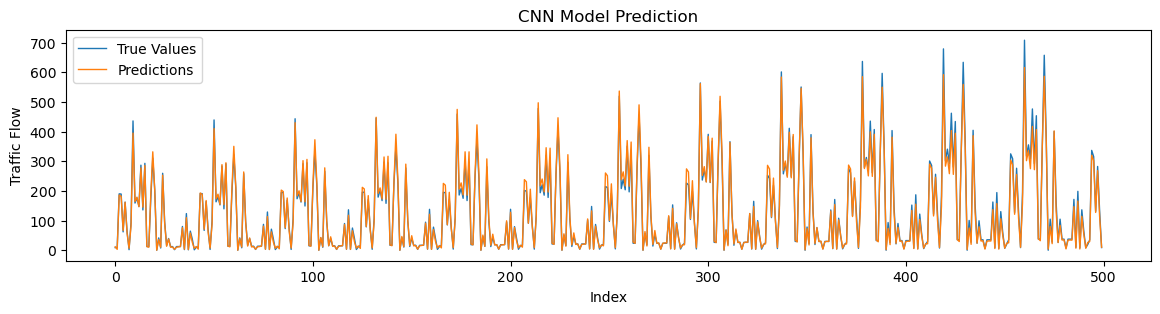

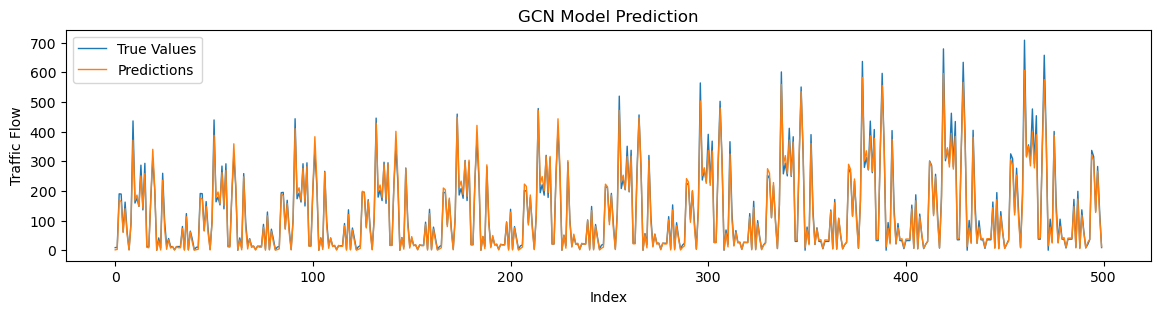

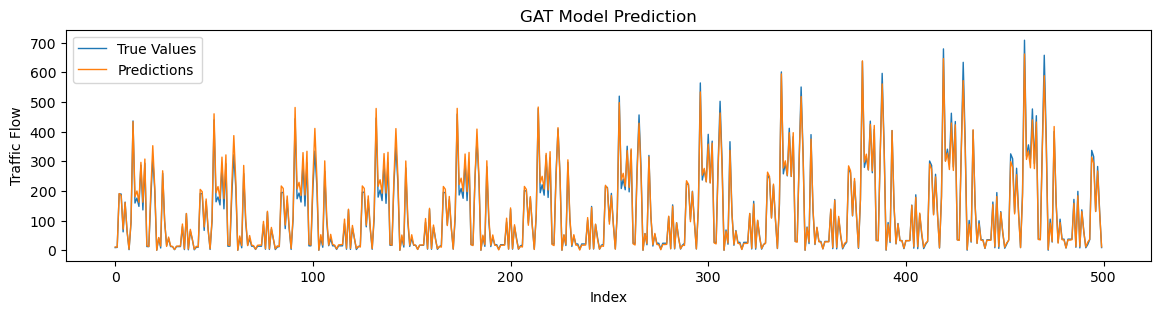

In [302]:
n = 500
visualize_predictions(st_grid_predictions['CNN'][:n], st_grid_target['CNN'][:n], 'CNN Model Prediction', 'Index')
visualize_predictions(st_graph_predictions['GCN'][:n], st_graph_target['GCN'][:n], 'GCN Model Prediction', 'Index')
visualize_predictions(st_graph_predictions['GAT'][:n], st_graph_target['GAT'][:n], 'GAT Model Prediction', 'Index')

### Station Level Graph

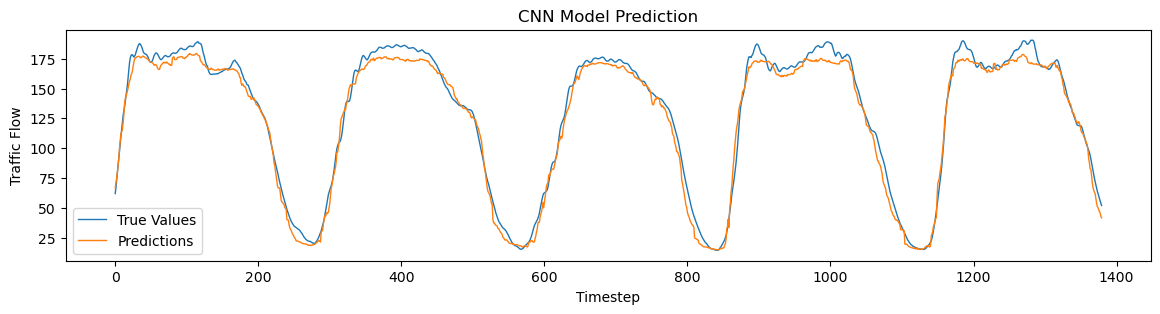

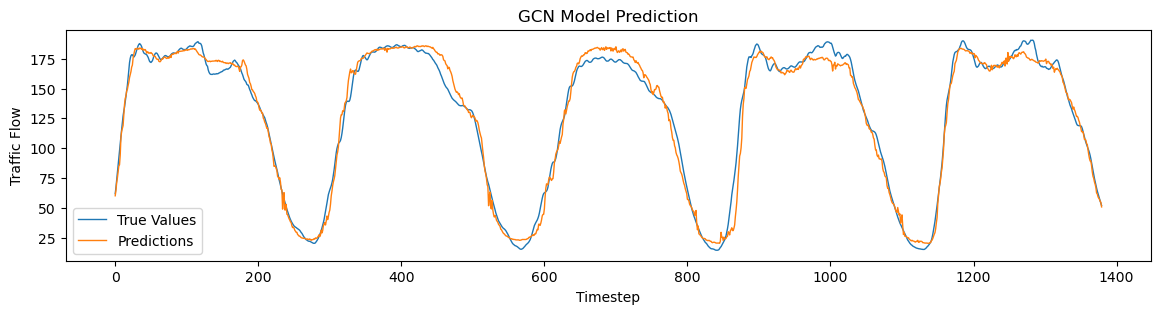

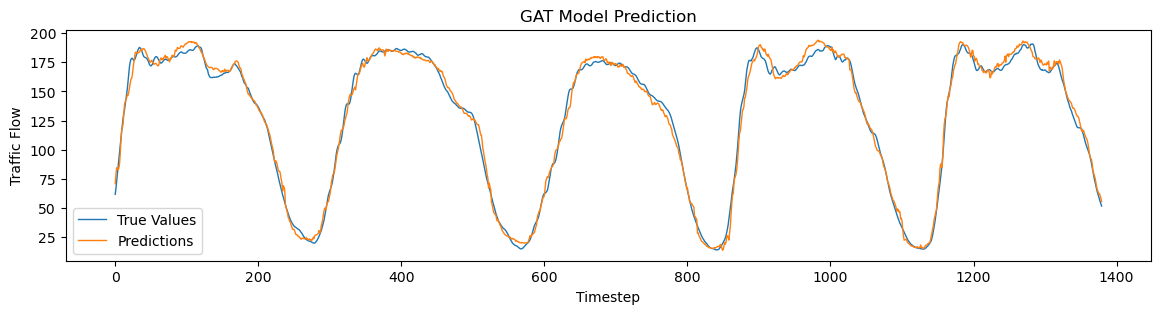

In [303]:
n = 4
visualize_predictions(st_grid_predictions['CNN'][n::len(nodes)], st_grid_target['CNN'][n::len(nodes)], 'CNN Model Prediction')
visualize_predictions(st_graph_predictions['GCN'][n::len(nodes)], st_graph_target['GCN'][n::len(nodes)], 'GCN Model Prediction')
visualize_predictions(st_graph_predictions['GAT'][n::len(nodes)], st_graph_target['GAT'][n::len(nodes)], 'GAT Model Prediction')

## LONG-TERM PREDICTION

### Overall Graph

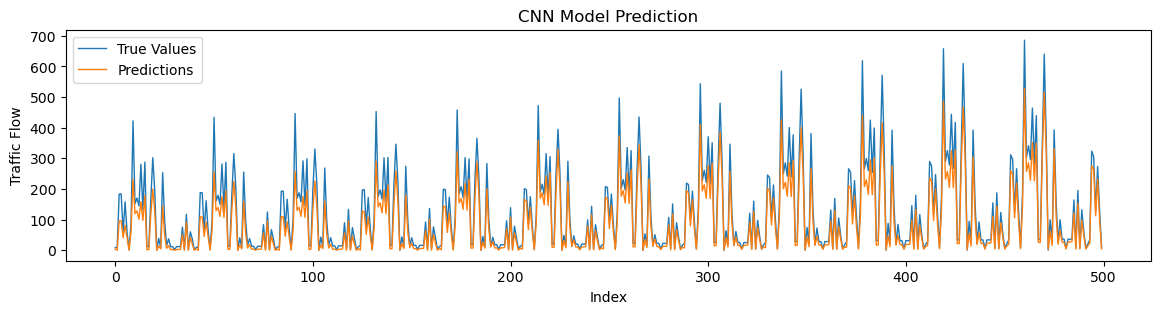

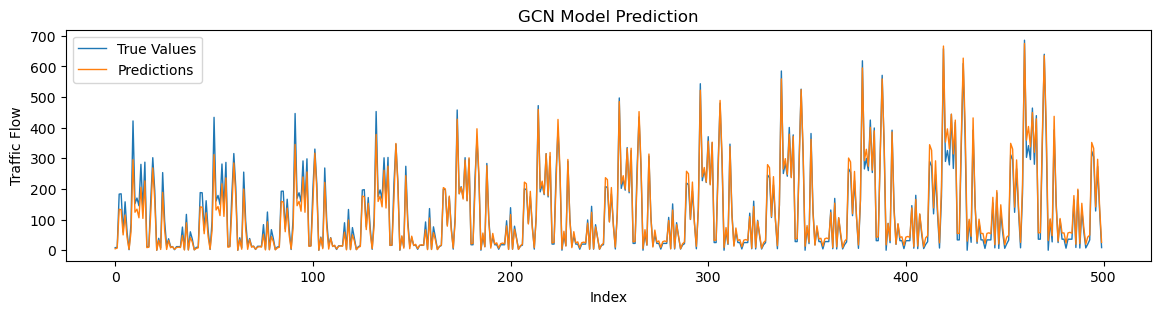

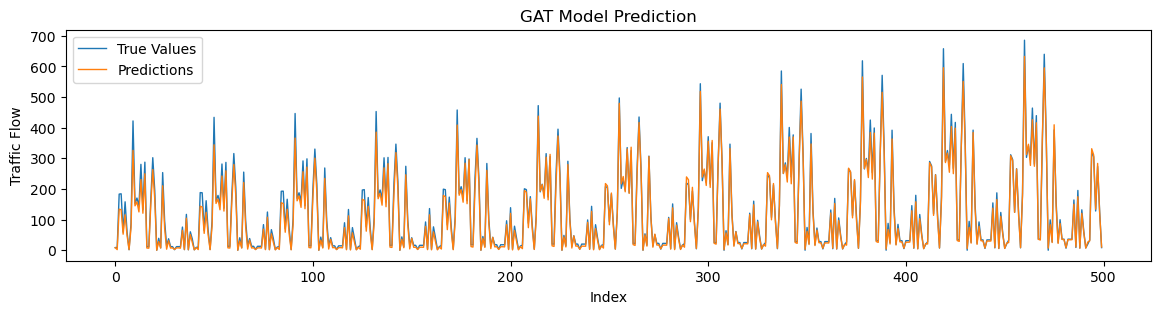

In [304]:
n = 500
visualize_predictions(lt_grid_predictions['CNN'][:n], lt_grid_target['CNN'][:n], 'CNN Model Prediction', 'Index')
visualize_predictions(lt_graph_predictions['GCN'][:n], lt_graph_target['GCN'][:n], 'GCN Model Prediction', 'Index')
visualize_predictions(lt_graph_predictions['GAT'][:n], lt_graph_target['GAT'][:n], 'GAT Model Prediction', 'Index')

### Station Level Graph

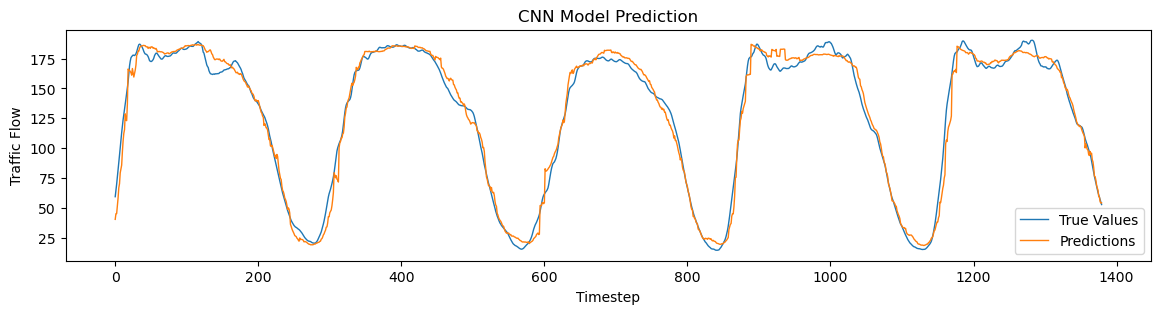

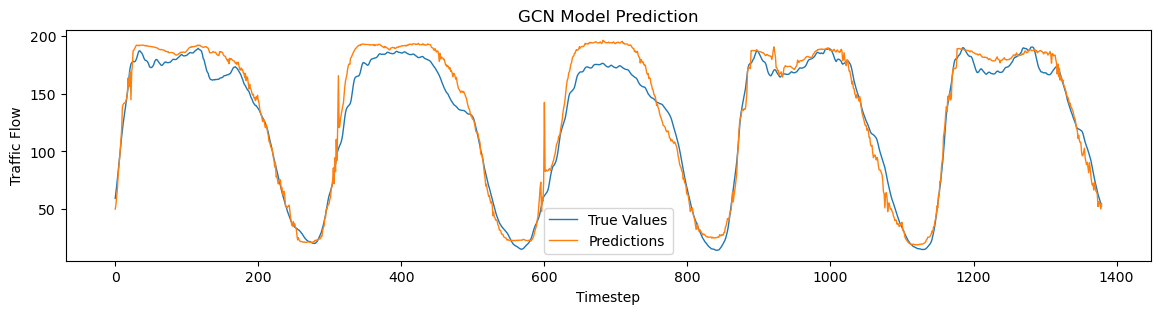

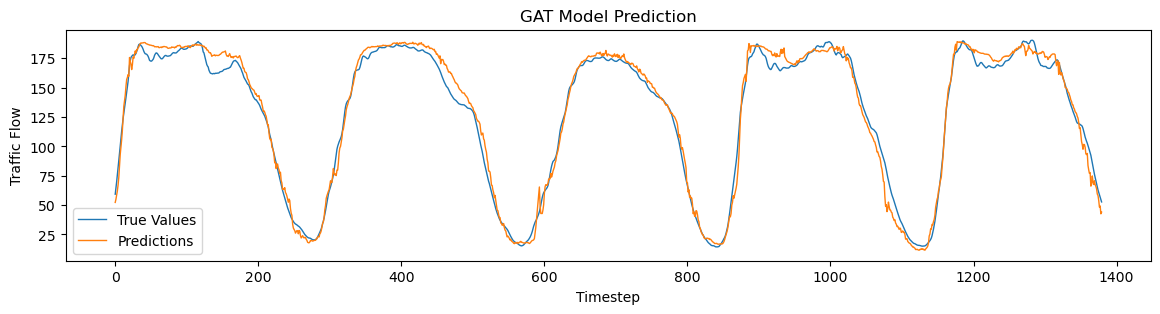

In [305]:
n = 4
visualize_predictions(lt_grid_predictions['CNN'][n::len(nodes)], lt_grid_target['CNN'][n::len(nodes)], 'CNN Model Prediction')
visualize_predictions(lt_graph_predictions['GCN'][n::len(nodes)], lt_graph_target['GCN'][n::len(nodes)], 'GCN Model Prediction')
visualize_predictions(lt_graph_predictions['GAT'][n::len(nodes)], lt_graph_target['GAT'][n::len(nodes)], 'GAT Model Prediction')

# MODEL APPLICATION: DECISION SUPPORT SYSTEM

## TRANSFORM DATA

In [306]:
dss_df = create_rl_data(st_graph_predictions['GAT'], st_graph_target['GAT'],filtered_meta_df, index_node_map)
opp_dss_df = find_nearest_opposite_stations(filtered_meta_df.reset_index(drop=True))
dss_df = map_opp_stations(dss_df, opp_dss_df)
dss_df.head(2)

,timestep,highway,freeway_direction,lanes,target_avg_per_lane,pred_avg_per_lane,station_id,station_id_nearest_station,freeway_direction_nearest_station,lanes_nearest_station,target_avg_per_lane_nearest_station,pred_avg_per_lane_nearest_station
0,0,55,N,1,8.833333,11.166667,1203252,1203264,S,1,9.500000,10.166667
1,0,55,S,1,9.500000,10.166667,1203264,1209873,N,3,41.166667,41.277779


In [307]:
dss_check_timestep = 6
dss_df = dss_df[(dss_df['lanes']>1) & (dss_df['lanes_nearest_station']>1)].copy()
dss_df = dss_df[dss_df['timestep']%dss_check_timestep==0]

## MODEL TRAINING 1 (5 EPISODES)

In [308]:
q_table, predict_action, state_space = rl_model(dss_df, 5)
q_df = pd.DataFrame(q_table, columns = ['No_Reversal', 'Reversal'])
q_df[['Reference_Station_Traffic', 'Opp_Station_Traffic']] = state_space
q_df['Lane_Reversal'] = q_df['Reversal'] > q_df['No_Reversal']
print("Trained Q-Table:")
q_df[['Reference_Station_Traffic', 'Opp_Station_Traffic', 'No_Reversal', 'Reversal', 'Lane_Reversal']].head(5)

Trained Q-Table:


,Reference_Station_Traffic,Opp_Station_Traffic,No_Reversal,Reversal,Lane_Reversal
0,0.0,0.0,69.963174,58.102735,False
1,20.0,0.0,65.913191,51.393927,False
2,40.0,0.0,16.839434,48.448608,True
3,60.0,0.0,0.000000,46.348833,True
4,80.0,0.0,0.000000,50.466634,True


## MODEL EVALUATION 1 (5 EPISODES)

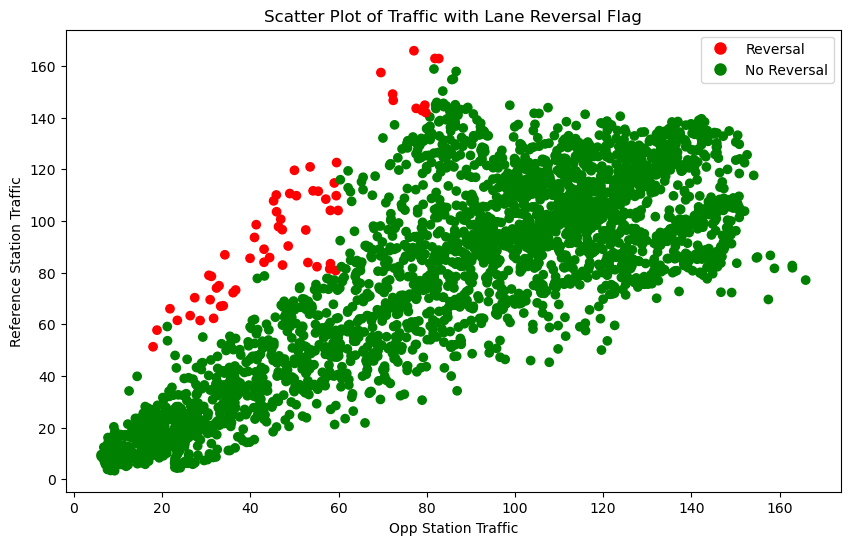

In [309]:
vectorized_predict_action = np.vectorize(predict_action)
actions = vectorized_predict_action(dss_df['pred_avg_per_lane'], dss_df['pred_avg_per_lane_nearest_station'])
dss_df['lane_reversal'] = (actions)
dss_result_plot(dss_df)

## MODEL TRAINING 2 (100 EPISODES)

In [310]:
q_table, predict_action, state_space = rl_model(dss_df, 100)
q_df = pd.DataFrame(q_table, columns = ['No_Reversal', 'Reversal'])
q_df[['Reference_Station_Traffic', 'Opp_Station_Traffic']] = state_space
q_df['Lane_Reversal'] = q_df['Reversal'] > q_df['No_Reversal']
print("Trained Q-Table:")
q_df[['Reference_Station_Traffic', 'Opp_Station_Traffic', 'No_Reversal', 'Reversal', 'Lane_Reversal']].head(5)

Trained Q-Table:


,Reference_Station_Traffic,Opp_Station_Traffic,No_Reversal,Reversal,Lane_Reversal
0,0.0,0.0,75.251706,65.681534,False
1,20.0,0.0,72.936199,55.432886,False
2,40.0,0.0,45.862383,51.941871,True
3,60.0,0.0,0.000000,52.073907,True
4,80.0,0.0,0.000000,55.720800,True


## MODEL EVALUATION 2 (100 EPISODES)

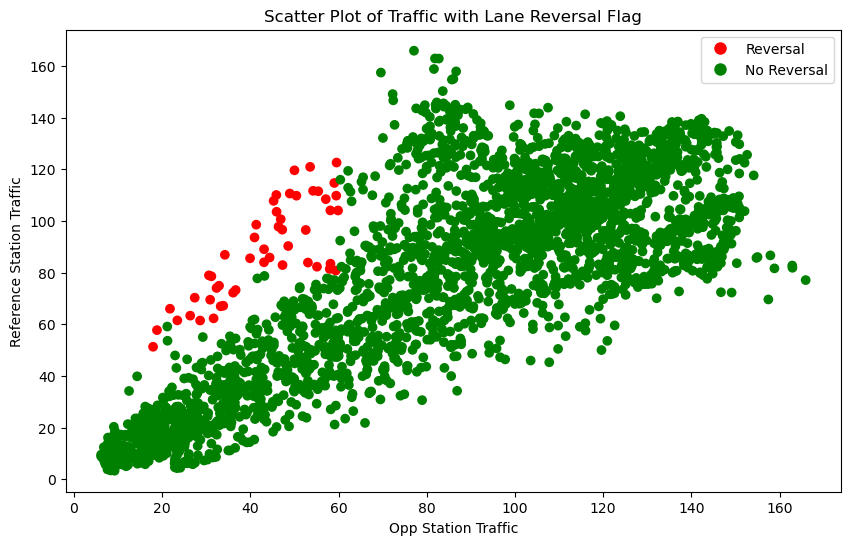

In [311]:
vectorized_predict_action = np.vectorize(predict_action)
actions = vectorized_predict_action(dss_df['pred_avg_per_lane'], dss_df['pred_avg_per_lane_nearest_station'])
dss_df['lane_reversal'] = (actions)
dss_result_plot(dss_df)

## DSS INFERENCE MODE

In [314]:
# Example prediction
example_pred_current = 121
example_pred_opposite = 40

action = predict_action(example_pred_current, example_pred_opposite)
print(f"Predicted action: {'Reversal Needed' if action == 1 else 'No Reversal Needed'}")


Predicted action: Reversal Needed
